In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import _draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D, base
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

print(tf.__version__)

Using TensorFlow backend.


1.13.2


In [29]:
def show_img(img, vmin=None, vmax=None, cmap='magma', figsize=(8,8)):
    plt.imshow(np.squeeze(img),vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axis('off')

In [37]:
def show_imgs(imgs, vmin=None, vmax=None, cmap='magma', figsize=(8,40)):
    col = len(imgs)
    plt.figure(figsize=figsize)
    for c in range(0,col):
        plt.subplot(1, col, c+1)
        if isinstance(imgs, list): img = imgs[c]
        else: img = imgs
        plt.imshow(np.squeeze(img),vmin=vmin, vmax=vmax, cmap=cmap)
        plt.axis('off')

In [27]:
def show_arrs(arrs, vmin=None, vmax=None, cmap='magma', figsize=(8,8)):
    ## arrs is img or img list array
    ## arr can be a single img or a list of images (will be plot in cols)
    for i, arr in enumerate(arrs):
        col = len(arr)
        plt.figure(figsize=figsize)
        plt.title(i)
        for c in range(0,col):
            plt.subplot(1, col, c+1)
            if isinstance(arr, list): img = arr[c]
            else: img = arr
            plt.imshow(np.squeeze(img),vmin=vmin, vmax=vmax, cmap=cmap)
            plt.axis('off')

In [3]:
def show_img_pred(image, prob, lossP_img, lossD_img, idx,  pmax=None, dmax=None, cmap='magma', figsize=(20,5)):
    ''' X_batch, Y_batch is obtained from StarDistData2D data generator
        idx is the idx of images to be ploted
    '''
    ## plot each row corresponding to each image(idx)
    for i in idx:
        plt.figure(figsize=figsize)
        
        for c, img in enumerate([image[i], prob[i], lossP_img[i], lossD_img[i]]):
            plt.subplot(1, 5, c+1)
            plt.title(f'{i}_{img.shape}')
            if c==2: 
                vmax=pmax
            elif c==3: 
                vmax=dmax
            else: 
                vmax=None
            plt.imshow(np.squeeze(img),vmin=0, vmax=vmax, cmap=cmap)
            plt.axis('off')
        
        img = normalize(np.squeeze(image[i]), 1,99.8, axis=(0,1))
        labels, _ = model.predict_instances(img)
        plt.subplot(1, 5, 5)
        plt.imshow(img, clim=(0,1), cmap='gray')
        plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
        plt.axis('off')  

In [4]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12275881789000027529
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7859301964338961577
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7699782042
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4104809601488068385
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13212158802207737028
physical_device_desc: "device: XLA_GPU device"
]


## Load sample data

In [7]:
import os
HOME = Path('/home/lis-paul')
# PATH = "data/dsb2018/dsb2018_sub1/"
PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

5 5


In [10]:
X = list(map(imread,X_file))
Y = list(map(imread,Y_file))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

# manual assign train/val index for debugging
ind_train = [1,2,3,4]
ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_file_val   = [X_file[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

100%|██████████| 5/5 [00:00<00:00, 57.88it/s]

number of images:   5
- training:         4
- validation:       1


In [11]:
X_file_val[:10]

['/home/lis-paul/data/centuri/train/images/V1a-DMSO-x40-E1-2.tif']

## Show example validation data

V1a-DMSO-x40-E1-2.tif


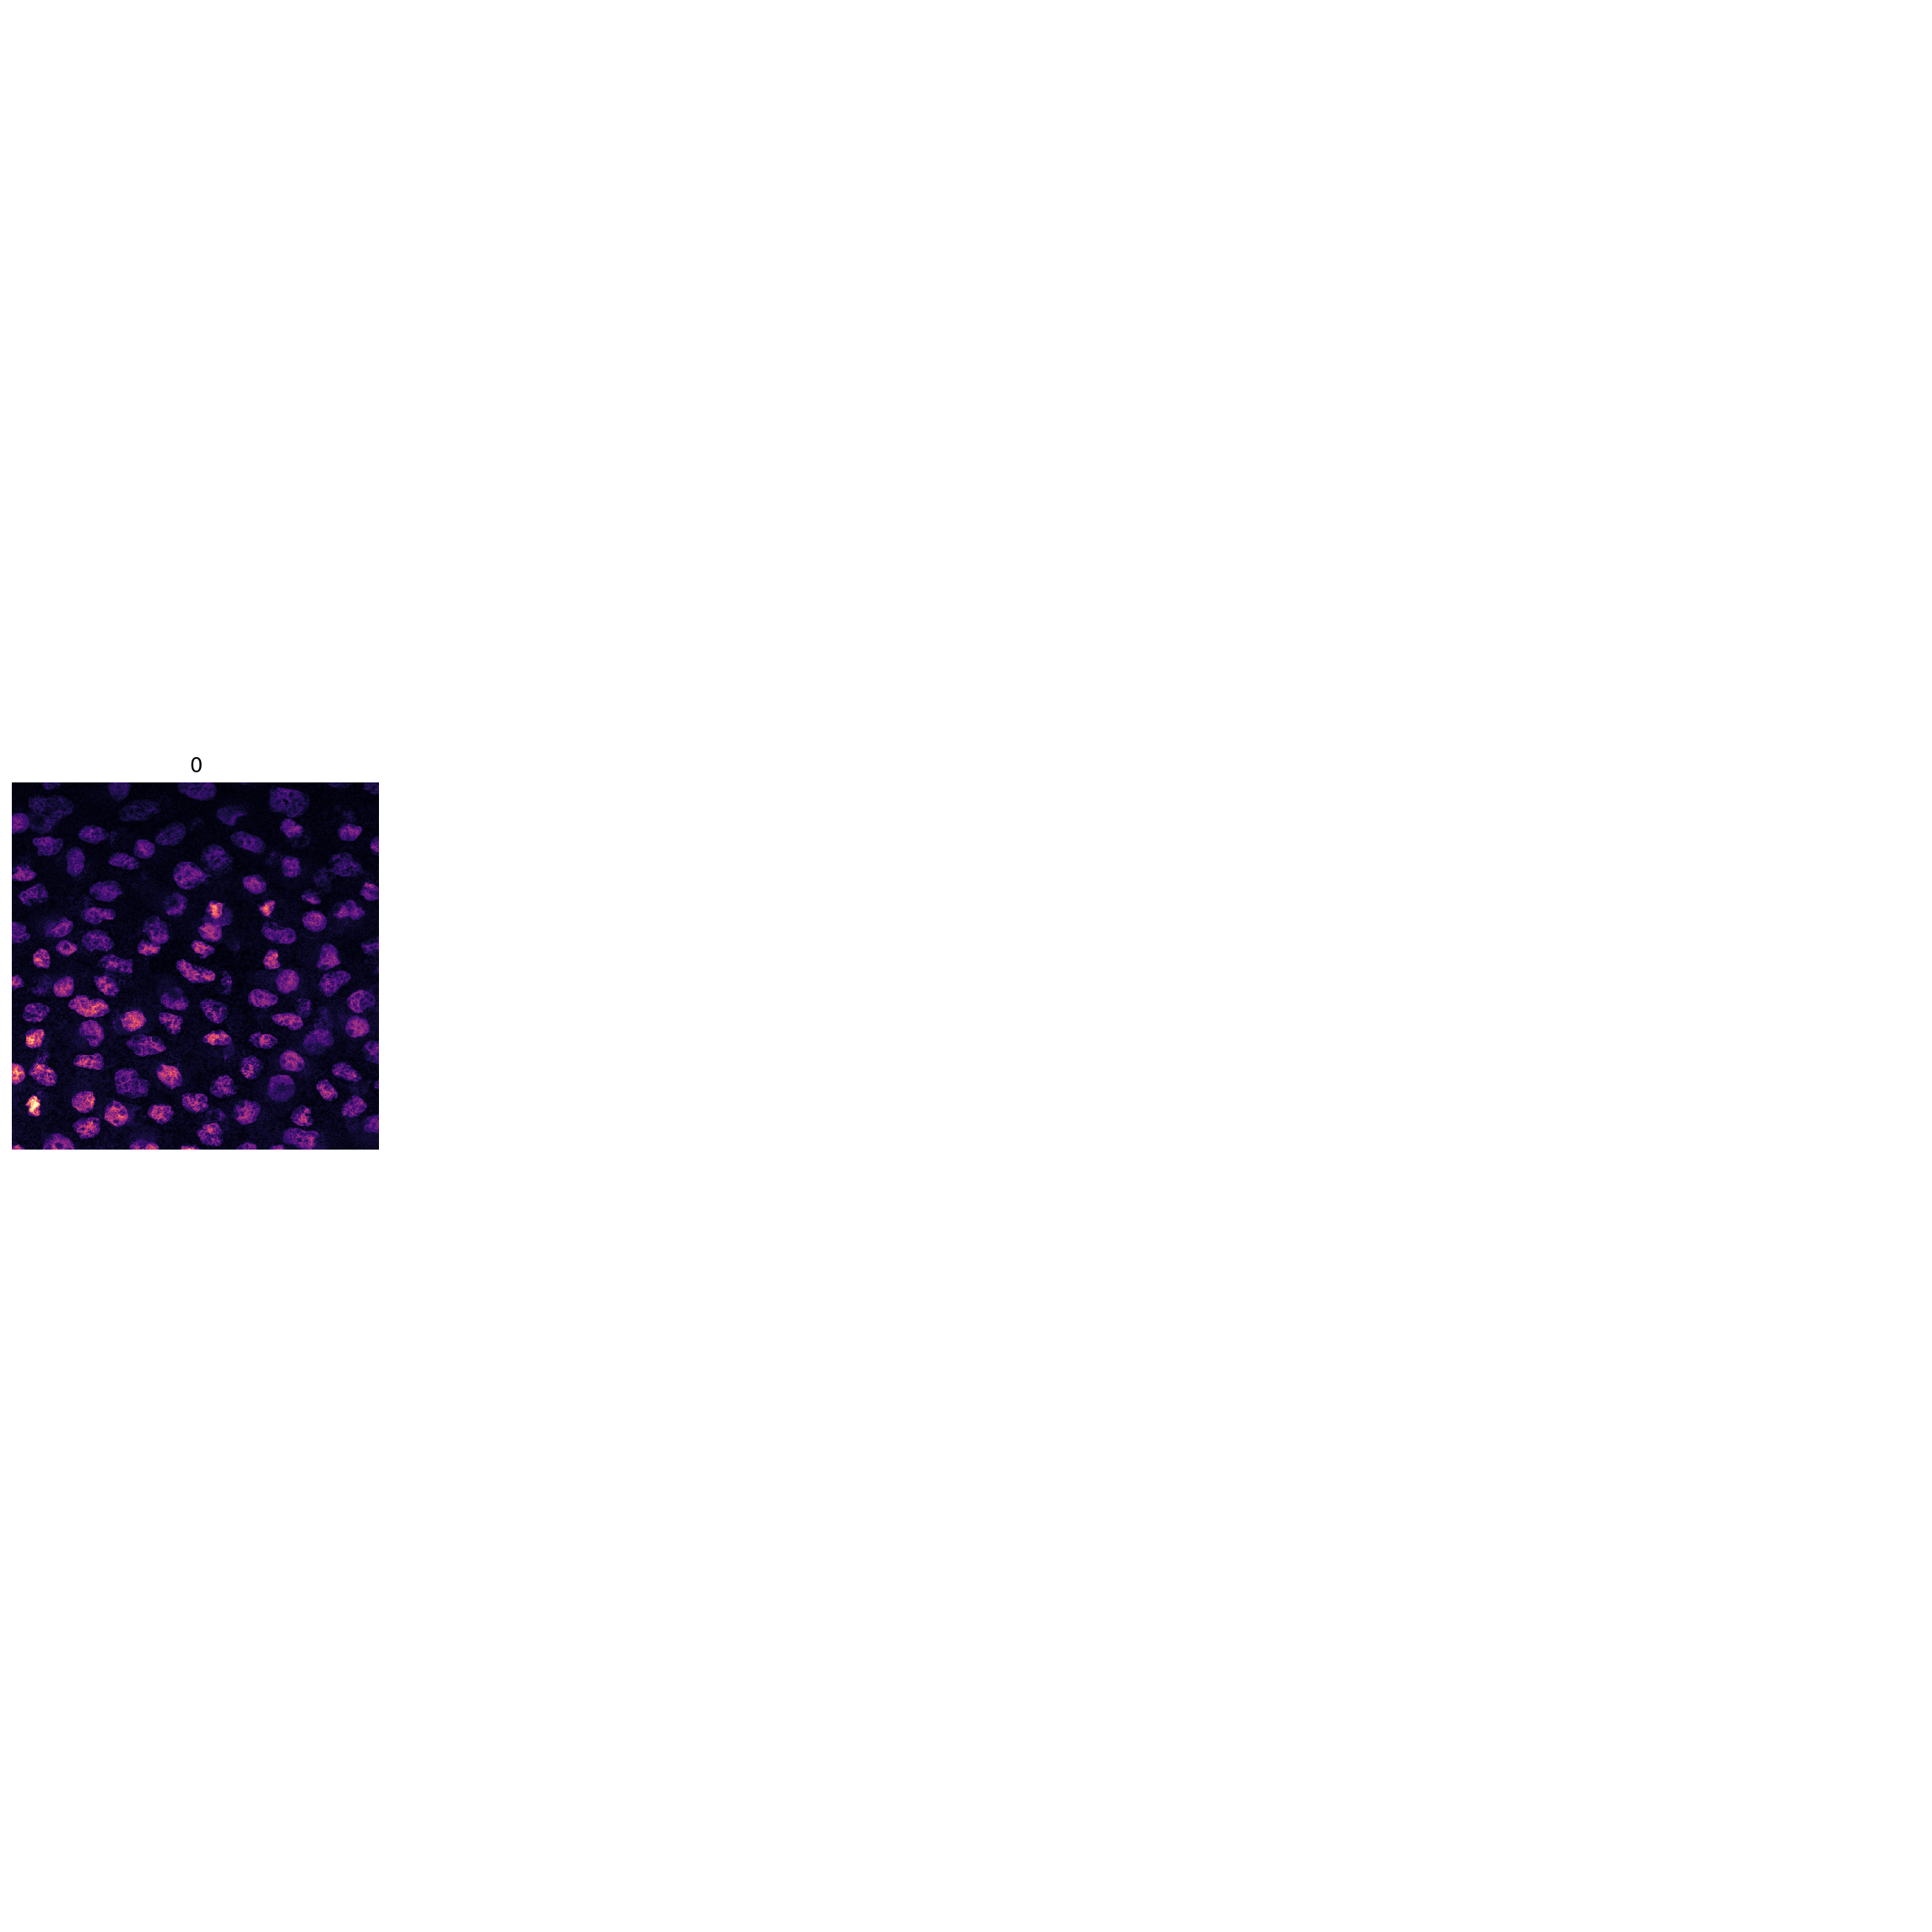

In [12]:
# show first 5 validation images

fig, ax = plt.subplots(1,5, figsize=(16,16))
for i,(a,x,f) in enumerate(zip(ax.flat, X_val[-5:], X_file_val)):
    a.imshow(x if x.ndim==2 else x[...,0], cmap='magma')
    a.set_title(i)
    print(os.path.basename(f))
[a.axis('off') for a in ax.flat]
plt.tight_layout()


# i = 5
# # img, lbl = X[i], Y[i]
# img, lbl = X_val[i], Y_val[i]
# assert img.ndim in (2,3)
# img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
# plt.figure(figsize=(16,10))
# plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
# plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
# None;

# img.shape

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [10]:
import cv2
from albumentations import *

In [11]:
ranf=list(np.random.ranf(8)/5)
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
    ShiftScaleRotate(shift_limit=0, scale_limit=(0.0, 1.2), rotate_limit=10, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, always_apply=False, p=1),
    CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=1),
    GaussNoise(var_limit=(0.0, 0.15), mean=0, always_apply=False, p=0.5),
    GaussianBlur(blur_limit=33, p=0.5),
    ElasticTransform(alpha=100, sigma=7, alpha_affine=1, p=0.7, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),
], p=0.95)

## Train with augmentations

In [21]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = False,
    n_channel_in = n_channel,
    train_batch_size = 4, 
    train_epochs = 100,
    train_steps_per_epoch = 20,
    train_one_cycle_lr_max = 3e-4,
    train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 1e-5},
    train_loss_weights=(1, 0.2),
    unet_dropout=0.2,
    train_foreground_only=0.99,
    y_range = None,
    norm_by_mask=False,
    EDT_border_R=25,
    EDT_black_border=True,
    unet_batch_norm=True
#     train_background_reg=0.0005,  #instead of 0.0001
#     train_learning_rate=0.008
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(EDT_black_border=True, EDT_border_R=25, EDT_prob_threshold=0, axes='YXC', backbone='unet', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), norm_by_mask=False, train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=100, train_foreground_only=0.99, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 1e-05}, train_shape_completion=False, train_steps_per_epoch=20, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.2, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_d

In [22]:
model = StarDist2D(conf, name='stardist', basedir='test0418')

/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/qzt/stardist/examples/2D/test0418/stardist
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
# %%debug
# AUGMENTATIONS_TRAIN=None
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN, multi=True, ncpu=8)

Epoch 1/100
20/20 [==============================] - 18s 902ms/step - loss: 0.2794 - prob_loss: 0.1236 - dist_loss: 0.7788 - prob_kld: 0.6303 - dist_relevant_mae: 23.9201 - dist_relevant_mse: 899.9043 - val_loss: 0.2576 - val_prob_loss: 0.1258 - val_dist_loss: 0.6589 - val_prob_kld: 0.6105 - val_dist_relevant_mae: 18.2278 - val_dist_relevant_mse: 463.7410
Epoch 2/100
20/20 [==============================] - 16s 787ms/step - loss: 0.2754 - prob_loss: 0.1201 - dist_loss: 0.7766 - prob_kld: 0.6050 - dist_relevant_mae: 24.4666 - dist_relevant_mse: 936.3803 - val_loss: 0.2591 - val_prob_loss: 0.1274 - val_dist_loss: 0.6585 - val_prob_kld: 0.5784 - val_dist_relevant_mae: 18.2177 - val_dist_relevant_mse: 463.3768
Epoch 3/100
20/20 [==============================] - 15s 761ms/step - loss: 0.2829 - prob_loss: 0.1196 - dist_loss: 0.8164 - prob_kld: 0.5843 - dist_relevant_mae: 26.5035 - dist_relevant_mse: 1112.9938 - val_loss: 0.2596 - val_prob_loss: 0.1280 - val_dist_loss: 0.6581 - val_prob_kld:

Probably due to custom activation function (lambda function), not be able to save model

In [23]:
# model.keras_model.save('1b_100s_400e.h5') 

# model.keras_model.load_weights('1b_100s_400e.h5')

# model.keras_model.summary()

In [ ]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=4, n_rays=32, patch_size=(256,256), augmenter=None, shape_completion=False)

## load previous model

In [13]:
from keras import backend as K
K.clear_session()
# sess = K.get_session()
# tf.reset_default_graph()
# model = StarDist2D(None, name='stardist_depth_3_augment_True_grid_2_2_epochs_800', basedir='../../models')
# model = StarDist2D(None, name='stardist_tune', basedir='unet01')
model = StarDist2D(None, name='stardist', basedir='AUGA10_b4_unet2_bn_drop0.2_huber0.05w3_distPow3_EDTbR25_EDTbb_lossW20-1_fg1_bgr1e-3_oclr3e-5_xenopus')

if not model._model_prepared:
    model.prepare_for_training()
model.config

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.00404242, nms_thresh=0.3.


Config2D(EDT_black_border=True, EDT_border_R=25, EDT_prob_threshold=0, axes='YXC', backbone='unet2', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], norm_by_mask=True, train_background_reg=0.001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=200, train_foreground_only=1, train_learning_rate=0.0003, train_loss_weights=[20, 1], train_n_val_patches=None, train_one_cycle_lr_max=3e-05, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=50, train_tensorboard=True, unet_activation='relu', unet_batch_norm=True, unet_dropout=0.2, unet_kernel_init='he_uniform', unet_kernel_size=[3, 3], unet_last_activation='r

In [13]:
model.keras_model.loss_functions[0]

<function stardist.models.base.huber_loss_percentile.<locals>._loss(y_true, y_pred)>

In [9]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [28]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:14<00:03,  1.09it/s, 0.490 -> 0.889]


Using optimized values: prob_thresh=0.46908, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.46907995878230185, 'nms': 0.3}

## Model Evaluation

In [18]:
def get_top_losses(model, X_batch, Y_batch, sort=True):
    assert len(X_batch) == len(Y_batch)
  
    img_patches = X_batch[0]
    dummy = np.empty(img_patches.shape, np.float32)

    y_prob = Y_batch[0]
    y_dist = Y_batch[1]
    
    pred_prob, pred_dist = model.keras_model.predict([img_patches, dummy])
    
    ## get the probability loss function
    l1 = model.keras_model.loss_functions[0]
    ## get the distance loss function
    l2 = model.keras_model.loss_functions[1]
    ## build the tf graph of loss calculation
    loss_prob = l1(tf.convert_to_tensor(y_prob), tf.convert_to_tensor(pred_prob))
    loss_dist = l2(tf.convert_to_tensor(y_dist), tf.convert_to_tensor(pred_dist))
    ## reduce over the image wxh dimension but keep the batchsize dimension 
    ## so that loss is not averaged over the whole batch. To get loss for each sample
    #loss_prob_m = tf.math.reduce_mean(loss_prob, axis=(1,2))
    axP = np.arange(1,tf.keras.backend.ndim(loss_prob))
    axD = np.arange(1,tf.keras.backend.ndim(loss_dist))
    loss_prob_m = tf.math.reduce_mean(loss_prob, axis=axP)
    loss_dist_m = tf.math.reduce_mean(loss_dist, axis=axD)

    with tf.Session() as sess:
        loss_prob, loss_prob_m = sess.run([loss_prob, loss_prob_m],feed_dict={'dist_mask:0':y_prob} )
        loss_dist, loss_dist_m = sess.run([loss_dist, loss_dist_m],feed_dict={'dist_mask:0':y_prob} )
        
    ## create index number, and concatenate to reduced loss tensor
#     idx = np.arange(0, len(loss_prob_m))
    idx = np.arange(0,len(X_batch[0]))
    loss_prob_m = np.c_[idx, loss_prob_m]
    loss_dist_m = np.c_[idx, loss_dist_m]
    ## sort in descending manner
    if sort:
        sortP = (-loss_prob_m[:,1]).argsort()
        sortD = (-loss_dist_m[:,1]).argsort()
        loss_prob_m = loss_prob_m[sortP]
        loss_dist_m = loss_dist_m[sortD]
        loss_prob   = loss_prob[sortP]
        loss_dist   = loss_dist[sortD]
    
    return (loss_prob_m, loss_prob), (loss_dist_m, loss_dist), (pred_prob, pred_dist)

In [19]:
nr = model.config.n_rays
ps = model.config.train_patch_size
grid = model.config.grid
bs = len(X_val)

data = StarDistData2D(X_val, Y_val, batch_size=bs, n_rays=nr, grid=grid, patch_size=ps, 
                           shuffle_start=False,augmenter=None, shape_completion=False, b=0)
## data[0] is the first batch of the generator
## data[0][0] is the X part of each batch, which is a list of [img, dist_mask]
## data[0][1] is the Y part of each batch, which is a tuple of [prob, dist] 
X_batch, Y_batch = data[0]
# len(X_batch[0])

In [20]:
lossP, lossD, pred = get_top_losses(model, X_batch, Y_batch, sort=False)
lossP[0].shape, lossP[1].shape, lossD[0].shape, lossD[1].shape, pred[0].shape, pred[1].shape

((1, 2),
 (1, 128, 128, 1),
 (1, 2),
 (1, 128, 128),
 (1, 128, 128, 1),
 (1, 128, 128, 32))

In [21]:
img_patches = X_batch[0]
dummy = np.empty(img_patches.shape, np.float32)
img_patches.shape, dummy.shape

((1, 256, 256, 1), (1, 256, 256, 1))

In [22]:
y_prob = Y_batch[0]
y_dist = Y_batch[1]
dummy_dist = np.empty(y_prob.shape, np.float32)

y_prob.shape, y_dist.shape, dummy_dist.shape

((1, 128, 128, 1), (1, 128, 128, 32), (1, 128, 128, 1))

In [23]:
pred_prob, pred_dist = model.keras_model.predict([img_patches, dummy])
pred_prob.shape, pred_dist.shape

((1, 128, 128, 1), (1, 128, 128, 32))

In [41]:
np.savetxt('pred.txt', np.squeeze(pred_prob))

In [42]:
np.savetxt('loss.txt', np.squeeze(lossP[1]))

In [43]:
np.savetxt('dist.txt', np.squeeze(X_batch[1]))

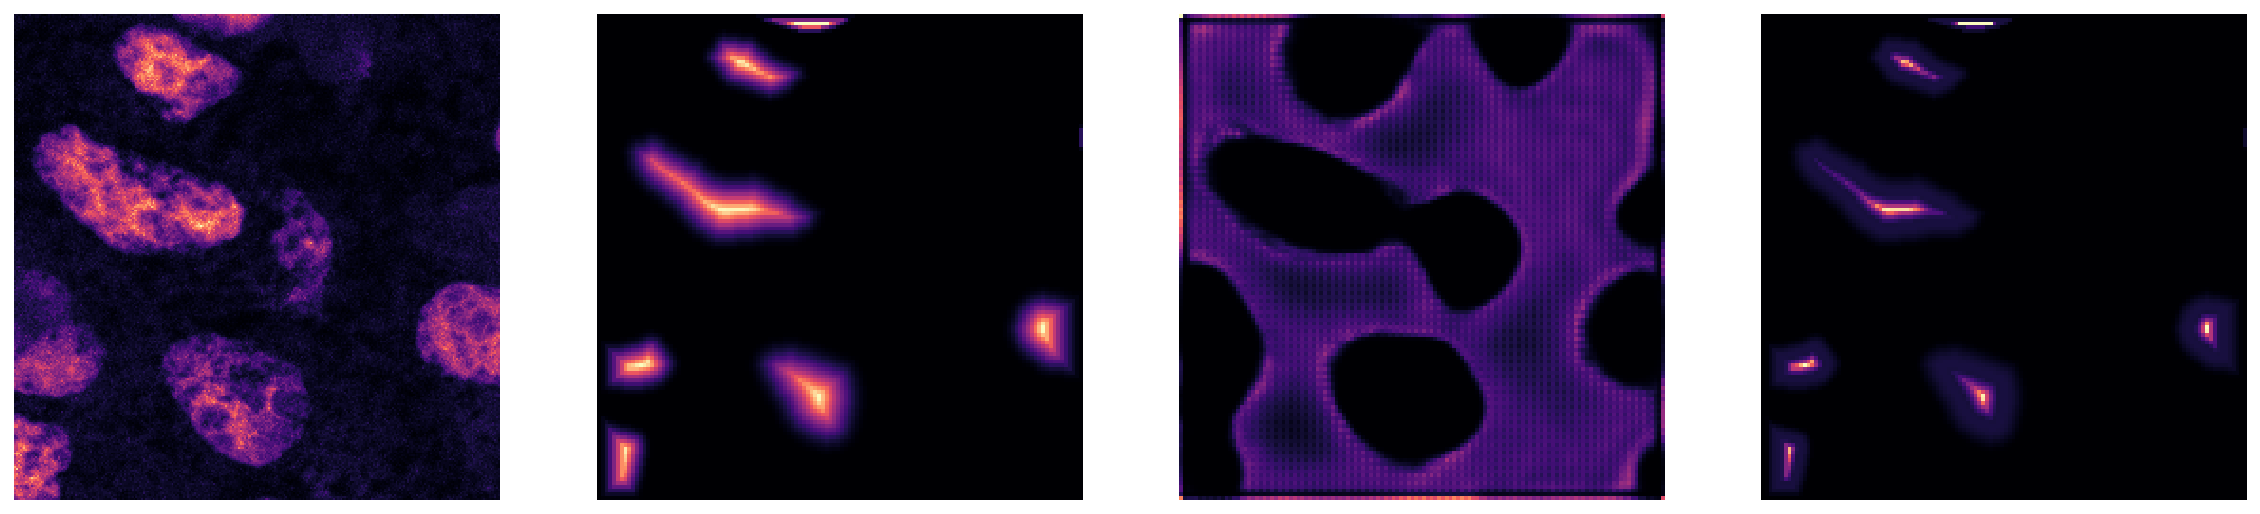

In [39]:
show_imgs([X_batch[0], X_batch[1], pred_prob, lossP[1]], figsize=(20,20))

In [ ]:
show_img_pred(X_batch[0], Y_batch[0], lossP[1], lossD[1], [6, 33,  1, 31, 26, 18, 35,  0], pmax=lossP[1].max(), dmax=lossD[1].max())

In [44]:
np.exp(0.4907)

1.633459241320152

In [46]:
0.5*0.05*0.05 + 0.05*0.9857

0.050535000000000004